In [1]:
import numpy as np
import xarray as xr

import itertools

from src.score import *
import re
from collections import OrderedDict


In [2]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

In [3]:
var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850])} 


ds_list = []

for long_var, params in var_dict.items():
    if long_var == 'constants':
        ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))
    else:
        var, levels = params
        if levels is not None:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords').sel(level = levels))
        else:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))

# because missing first values of solar radiation exclude these from the dataset
ds_whole = xr.merge(ds_list).isel(time = slice(7, None))

In [4]:
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

class DataGenerator():
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, 
                 mean=None, std=None, output_vars= None, bins_z = None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants': 
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)   

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(ds.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values) 
                                if any([bool(re.match(o, l)) for o in output_vars])]

        self.bins_z = np.linspace(self.data.isel(level =self.output_idxs).min(), self.data.isel(level =self.output_idxs).max(), 100) if bins_z is None else bins_z 
        self.binned_data = xr.DataArray((np.digitize(self.data.isel(level=self.output_idxs), self.bins_z)-1)[:,:,:,0], dims=['time', 'lat', 'lon'], coords={'time':self.data.time.values, 'lat': self.data.lat.values, 'lon': self.data.lon.values})
        
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        del ds
        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()
        if load: print('Loading data into RAM'); self.binned_data.load()            

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.binned_data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

bs=32
lead_time=120
output_vars = ['z_500']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2010')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)

dg_test = DataGenerator(
    ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z, shuffle=False, output_vars = output_vars)

Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [5]:
stacked_z_results = np.load('/rds/general/user/mc4117/home/WeatherBench/saved_pred_data/5_day_29_z_predictions.npy')

In [6]:
stacked_z_results.shape

(17400, 32, 64, 100)

In [16]:
del ds_test

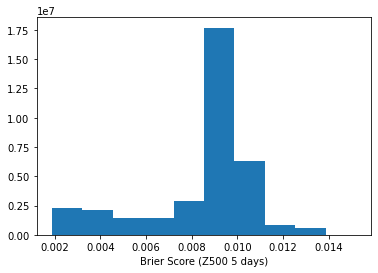

In [18]:
import pylab as plt

# brier
one_hot = np.eye(100)[np.array(dg_test.binned_data[120:]).reshape(-1)].reshape(stacked_z_results.shape)
brier_scores = 0.01*np.sum((stacked_z_results - one_hot)**2, axis = 3)
plt.hist(brier_scores.reshape(-1))
plt.xlabel('Brier Score (Z500 5 days)')
plt.show()

In [7]:
stacked_bin = stacked_z_results.argmax(axis = -1)

In [8]:
stacked_bin.shape

(17400, 32, 64)

In [9]:
# prob

sum(sum(sum(stacked_bin == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:])))

<xarray.DataArray ()>
array(0.21920621)

In [10]:
# shift + 1

stacked_shift_up = stacked_bin + 1

sum(sum(sum(stacked_shift_up == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:])))

<xarray.DataArray ()>
array(0.14136994)

In [11]:
# shift - 1

stacked_shift_down = stacked_bin - 1

sum(sum(sum(stacked_shift_down == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:])))

<xarray.DataArray ()>
array(0.10841853)

In [12]:
# sort all probabilities

prob_sort = stacked_z_results.argsort()
highest_prob = prob_sort[:, :, :, -1]
second_highest_prob = prob_sort[:, :, :, -2]
third_highest_prob = prob_sort[:, :, :, -3]
fourth_highest_prob = prob_sort[:, :, :, -4]
fifth_highest_prob = prob_sort[:, :, :, -5]

In [13]:
print(sum(sum(sum(highest_prob == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:]))))
print(sum(sum(sum(second_highest_prob == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:]))))
print(sum(sum(sum(third_highest_prob == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:]))))
print(sum(sum(sum(fourth_highest_prob == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:]))))
print(sum(sum(sum(fifth_highest_prob == dg_test.binned_data[120:])))/sum(sum(sum(dg_test.binned_data[120:] == dg_test.binned_data[120:]))))

<xarray.DataArray ()>
array(0.21920618)
<xarray.DataArray ()>
array(0.155354)
<xarray.DataArray ()>
array(0.09602971)
<xarray.DataArray ()>
array(0.06983974)
<xarray.DataArray ()>
array(0.05748069)


In [14]:
expected_value = np.dot(stacked_z_results, dg_test.bins_z)

In [15]:
nx, ny, nz = expected_value.shape

std_dev = np.zeros((nx, ny, nz))
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            std_dev[i][j][k] = np.sqrt(np.dot((dg_test.bins_z - expected_value[i][j][k])**2, stacked_z_results[i][j][k]))

In [16]:
std_dev_pos = expected_value + std_dev
std_dev_neg = expected_value - std_dev

std_dev_two_pos = expected_value + (2*std_dev)
std_dev_two_neg = expected_value - (2*std_dev)

std_dev_three_pos = expected_value + (3*std_dev)
std_dev_three_neg = expected_value - (3*std_dev)

In [17]:
real_values = ds_test.z.sel(level = 500)[120:]

In [18]:
within_one_std = ((real_values <= std_dev_pos) == ((real_values >= std_dev_neg)))
# number of values within 1 std deviation
print(sum(sum(sum(within_one_std.values)))/sum(sum(sum(np.array(real_values) == np.array(real_values)))))

within_two_std = ((real_values <= std_dev_two_pos) == ((real_values >= std_dev_two_neg)))
print(sum(sum(sum(within_two_std.values)))/sum(sum(sum(np.array(real_values) == np.array(real_values)))))

within_three_std = ((real_values <= std_dev_three_pos) == ((real_values >= std_dev_three_neg)))
print(sum(sum(sum(within_three_std.values)))/sum(sum(sum(np.array(real_values) == np.array(real_values)))))

0.6734805473239942
0.939533831716954
0.9886918833063937


In [19]:
# confidence intervals
real_array = np.array(real_values)

std_dev_90_pos = expected_value + (1.645*std_dev/10)
std_dev_90_neg = expected_value - (1.645*std_dev/10)
within_90_std = ((real_values <= std_dev_90_pos) == ((real_values >= std_dev_90_neg)))
print(sum(sum(sum(within_90_std.values)))/sum(sum(sum((real_array == real_array)))))

std_dev_95_pos = expected_value + (1.96*std_dev/10)
std_dev_95_neg = expected_value - (1.96*std_dev/10)
within_95_std = ((real_values <= std_dev_95_pos) == ((real_values >= std_dev_95_neg)))
print(sum(sum(sum(within_95_std.values)))/sum(sum(sum((real_array == real_array)))))

std_dev_99_pos = expected_value + (2.326*std_dev/10)
std_dev_99_neg = expected_value - (2.326*std_dev/10)
within_99_std = ((real_values <= std_dev_99_pos) == ((real_values >= std_dev_99_neg)))
print(sum(sum(sum(within_99_std.values)))/sum(sum(sum((real_array == real_array)))))

0.1234363213900862
0.147003243983477
0.17427594064295976


0.008516494926364943
0.008433711610991379
0.008535549119971264
0.009459859913793103
0.010747407058189655
0.011735559222341953
0.011710471668462643
0.01131134383979885
0.010692293013649426
0.010329814340876436
0.01112383261494253
0.012480075880028736
0.01297467111170977
0.010272315014367817
0.007945149739583334
0.0070643913882902296
0.006999567843031609
0.008002761314655172
0.009764025457974139
0.0114794921875
0.011923547503591954
0.012282490346623563
0.012085101248204022
0.011382705863864943
0.010991968615301724
0.010419276445761494
0.010009344692887931
0.009366160425646551
0.008887813173491379
0.009211818651221265
0.010078461745689654
0.010301976697198276


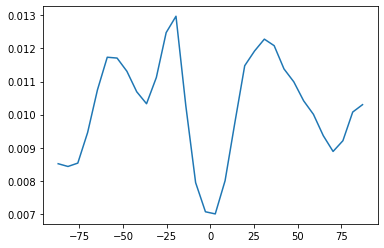

In [23]:
# where is most of the error
real_array = np.array(real_values)
not_within_one_std = ((real_values > std_dev_pos) != ((real_values < std_dev_neg)))
for i in range(32): 
    print(sum(sum(not_within_one_std[:,i,:].values))/sum(sum(sum((real_array == real_array)))))
import pylab as plt
import numpy as np
error_loc = [0.008516494926364943, 0.008433711610991379, 0.008535549119971264, 0.009459859913793103,
0.010747407058189655, 0.011735559222341953, 0.011710471668462643, 0.01131134383979885, 0.010692293013649426,
0.010329814340876436, 0.01112383261494253, 0.012480075880028736, 0.01297467111170977, 0.010272315014367817,
0.007945149739583334, 0.0070643913882902296, 0.006999567843031609, 0.008002761314655172, 0.009764025457974139,
0.0114794921875, 0.011923547503591954, 0.012282490346623563, 0.012085101248204022, 0.011382705863864943,
0.010991968615301724, 0.010419276445761494, 0.010009344692887931, 0.009366160425646551, 0.008887813173491379,
0.009211818651221265, 0.010078461745689654, 0.010301976697198276]
lat = np.array([-87.1875, -81.5625, -75.9375, -70.3125, -64.6875, -59.0625, -53.4375,
       -47.8125, -42.1875, -36.5625, -30.9375, -25.3125, -19.6875, -14.0625,
        -8.4375,  -2.8125,   2.8125,   8.4375,  14.0625,  19.6875,  25.3125,
        30.9375,  36.5625,  42.1875,  47.8125,  53.4375,  59.0625,  64.6875,
        70.3125,  75.9375,  81.5625,  87.1875])

plt.plot(lat, error_loc)

In [20]:
print(std_dev.mean())
print(std_dev.max())
print(std_dev.min())

629.8909471989472
2198.514333093191
119.06886669271282
